In [1]:
import os
import shutil
import numpy as np
import metamaps

/home/jupyter-account/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/jupyter-account/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = 'metamaps'

# The directory where we will
# store our smaller dataset
base_dir = 'metamaps_input'

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

def show_number_of_files_in_dir(dirname):
    print("Num files in '{}': {}".format(dirname,len(os.listdir(dirname))))

In [3]:
show_number_of_files_in_dir(original_dataset_dir)

Num files in 'metamaps': 34257


# Reset input directory
shutil.rmtree(base_dir)

In [4]:
def safe_create(dirname):
    if not os.path.exists(dirname):
        print("Creating '{}'".format(dirname))
        os.mkdir(dirname)
    else:
        print("'{}' already exists".format(dirname))

safe_create(base_dir)
safe_create(train_dir)
safe_create(validation_dir)
safe_create(test_dir)

'metamaps_input' already exists
'metamaps_input/train' already exists
'metamaps_input/validation' already exists
'metamaps_input/test' already exists


In [5]:
# Randomize the list of files
input_files = os.listdir(original_dataset_dir)
np.random.shuffle(input_files)

BUCKET_SIZE = 8500

def copy_bucket_of_maps(start_bucket,num_buckets,dest_dir):
    if len(os.listdir(dest_dir)) == 0:
        print("Copying {} files into '{}'".format(num_buckets*BUCKET_SIZE, dest_dir))
        start = start_bucket * BUCKET_SIZE
        end = (start_bucket + num_buckets) * BUCKET_SIZE
        for fname in input_files[start:end]:
            src = os.path.join(original_dataset_dir, fname)
            dst = os.path.join(dest_dir, fname)
            shutil.copyfile(src, dst)
    else:
        print("Skipped copying files into '{}'".format(dest_dir))

# Copy two buckets worth of metamaps images to train_dir
copy_bucket_of_maps(0,2,train_dir)

# Copy next bucket of metamaps to validation_cats_dir
copy_bucket_of_maps(2,1,validation_dir)
    
# Copy next bucket of metamaps to test_cats_dir
copy_bucket_of_maps(3,1,test_dir)

NUM_REAL_TRAIN_MAPS = 2 * BUCKET_SIZE
NUM_REAL_VALIDATION_MAPS = BUCKET_SIZE
NUM_REAL_TEST_MAPS = BUCKET_SIZE

Skipped copying files into 'metamaps_input/train'
Skipped copying files into 'metamaps_input/validation'
Skipped copying files into 'metamaps_input/test'


In [6]:
# Verify number of files in input directories
show_number_of_files_in_dir(train_dir)
show_number_of_files_in_dir(validation_dir)
show_number_of_files_in_dir(test_dir)

Num files in 'metamaps_input/train': 17000
Num files in 'metamaps_input/validation': 8500
Num files in 'metamaps_input/test': 8500


In [7]:
#Create model and add layers
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, len(metamaps.EncodingDim))))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
__________

In [9]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [10]:
BATCH_SIZE = 20

TRAINING_STEPS = int((NUM_REAL_TRAIN_MAPS * 2) / BATCH_SIZE)
VALIDATION_STEPS = int((NUM_REAL_VALIDATION_MAPS * 2) / BATCH_SIZE)

print("Training steps: {}".format(TRAINING_STEPS))
print("Validation steps: {}".format(VALIDATION_STEPS))

Training steps: 1700
Validation steps: 850


In [11]:
train_sequence = metamaps.MetaMapsSequence(train_dir,BATCH_SIZE)
validation_sequence = metamaps.MetaMapsSequence(validation_dir,BATCH_SIZE)

In [12]:
history = model.fit_generator(
      train_sequence,
      steps_per_epoch=TRAINING_STEPS, # number of batches to train with
      epochs=1, # this will get tweaked by looking at the overfitting curves
      validation_data=validation_sequence,
      validation_steps=VALIDATION_STEPS) # number of batches to validate with

Epoch 1/1
1700/1700 [==============================] - 1325s 780ms/step - loss: 0.0048 - acc: 0.9981 - val_loss: 1.1329e-07 - val_acc: 1.0000


In [13]:
model.save('real_vs_fake_metamaps.h5')

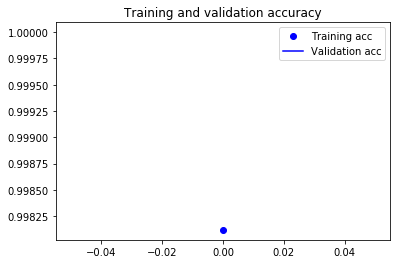

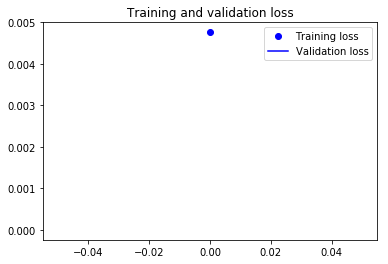

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()